## Introduction
Image Denoising  using Convolution Autoencoders



In many real-world applications, images are affected by noise introduced during acquisition, compression, or transmission. This noise degrades image quality and can significantly reduce the performance of downstream Machine Learning algorithms such as image classification, detection, or segmentation. Therefore, image denoising is an important pre-processing step to make images more amenable to Machine Learning models.

In this notebook, we explore image denoising using convolutional autoencoders applied to RGB photographs. A convolutional autoencoder is a neural network architecture composed of two main parts:

Encoder: compresses the input image into a lower-dimensional latent representation by learning meaningful visual features.

Decoder: reconstructs the original image from this latent representation, ideally removing noise while preserving important structures.

The objective of the autoencoder is not to classify images, but to reconstruct a clean version of an image from a noisy input. This makes autoencoders particularly well-suited for image denoising tasks.



## 1. Dataset Loading

The dataset consists of 148 RGB images stored in a local directory. The image file paths are first collected and filtered to include only valid image formats. 

In [16]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
DATA_DIR = r"C:\dev\photonon\delivable2"  #



In [17]:
import os
print(len(os.listdir(DATA_DIR)))
print(os.listdir(DATA_DIR)[:5])


148
['noisy_001.jpg', 'noisy_002.jpg', 'noisy_003.jpg', 'noisy_004.jpg', 'noisy_005.jpg']


In [18]:
import glob

# Collect image paths (only common image formats)
exts = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp")
image_paths = []

for ext in exts:
    image_paths.extend(glob.glob(os.path.join(DATA_DIR, ext)))

image_paths = sorted(image_paths)

print("Number of images:", len(image_paths))
print("First 5 image paths:")
image_paths[:5]


Number of images: 148
First 5 image paths:


['C:\\dev\\photonon\\delivable2\\noisy_001.jpg',
 'C:\\dev\\photonon\\delivable2\\noisy_002.jpg',
 'C:\\dev\\photonon\\delivable2\\noisy_003.jpg',
 'C:\\dev\\photonon\\delivable2\\noisy_004.jpg',
 'C:\\dev\\photonon\\delivable2\\noisy_005.jpg']

## 2.Dataset Splitting

To evaluate the model’s ability to generalize to unseen data, the dataset is divided into training and validation subsets. The image paths are first randomly shuffled to prevent any bias related to file ordering. The dataset is then split using an 80/20 ratio, where 80% of the images are used for training and 20% for validation. A fixed random seed is applied to ensure that the split is reproducible across different executions of the experiment.

In [19]:
import numpy as np

SEED = 42
rng = np.random.default_rng(SEED)

paths = image_paths.copy()
rng.shuffle(paths)

split_idx = int(0.8 * len(paths))  # 80/20 split
train_paths = paths[:split_idx]
val_paths = paths[split_idx:]

print("Train images:", len(train_paths))
print("Validation images:", len(val_paths))
print("Train sample:", train_paths[:2])
print("Val sample:", val_paths[:2])


Train images: 118
Validation images: 30
Train sample: ['C:\\dev\\photonon\\delivable2\\noisy_022.jpg', 'C:\\dev\\photonon\\delivable2\\noisy_091.jpg']
Val sample: ['C:\\dev\\photonon\\delivable2\\noisy_120.jpg', 'C:\\dev\\photonon\\delivable2\\noisy_018.jpg']


## 3.ImagePreprocessing

Before training the model, all images are resized to a fixed resolution and converted to floating-point values. Pixel intensities are normalized to the range 
[
0
,
1
]
[0,1] to improve training stability. This preprocessing step ensures that all images have a consistent format and are suitable for input into the convolutional autoencoder.

In [ ]:
import tensorflow as tf

IMG_H, IMG_W = 128, 128   
BATCH_SIZE = 8

def load_and_preprocess(path):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_H, IMG_W)) #forces  all the images to the same dimensions required because cnns expect fixed size imputs
    img = tf.cast(img, tf.float32) / 255.0  # [0,1] converts  pixel values  from integers  ands scales them to [0,1]
    return img

train_ds = tf.data.Dataset.from_tensor_slices(train_paths).map( #turns file paths into tensorflow dataset
    load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)

val_ds = tf.data.Dataset.from_tensor_slices(val_paths).map(
    load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)#groups the images into bathced  for fatser cpu utilization
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())


Train batches: 15
Val batches: 4


## 4.Noise Injection

To train the model for image denoising, artificial noise is added to the preprocessed images. Gaussian noise is applied to each image, and the resulting pixel values are clipped to remain within the valid range 
[
0
,
1
]
[0,1]. The noisy images are used as inputs to the autoencoder, while the original clean images are used as targets. This approach enables the model to learn how to reconstruct clean images from corrupted inputs.

In [ ]:
NOISE_FACTOR = 0.2  # for photos controls noise intensity

def make_noisy_pair(x):#function that takes a batch of clean images as input
    noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=1.0) #generates gaussian noise
    x_noisy = tf.clip_by_value(x + NOISE_FACTOR * noise, 0.0, 1.0)
    return x_noisy, x  # (input, target)

train_pairs = train_ds.map(make_noisy_pair, num_parallel_calls=tf.data.AUTOTUNE)#applies  noise injection
val_pairs   = val_ds.map(make_noisy_pair, num_parallel_calls=tf.data.AUTOTUNE)


## 5.Visualization

Visual representation of images and noisy images

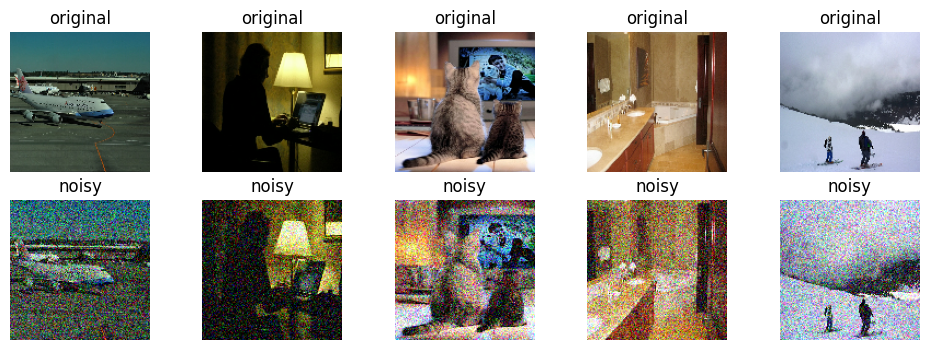

In [28]:
import matplotlib.pyplot as plt

for noisy, clean in train_pairs.take(1):
    plt.figure(figsize=(12, 4))
    for i in range(min(5, noisy.shape[0])):
        plt.subplot(2, 5, i + 1)
        plt.imshow(clean[i])
        plt.axis("off")
        plt.title("original")

        plt.subplot(2, 5, i + 6)
        plt.imshow(noisy[i])
        plt.axis("off")
        plt.title("noisy")
    plt.show()


## 6.Building the Encoder and Decoder

The model uses a convolutional autoencoder composed of an encoder and a decoder. The encoder consists of successive convolutional and max-pooling layers that progressively reduce the spatial dimensions of the input image while learning meaningful feature representations. This compressed representation captures the essential structure of the image while discarding noise.

The decoder mirrors the encoder by using upsampling and convolutional layers to gradually restore the image to its original resolution. The final layer uses a sigmoid activation function to reconstruct the denoised RGB image with pixel values constrained to the range 
[
0
,
1
]
[0,1]. This architecture enables the model to effectively remove noise while preserving important visual details

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Encoder
input_img = Input(shape=(IMG_H, IMG_W, 3)) #defines the input shape

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #conv2d learns the edges  textures etc creates 32 featuremaps of size 3*3
x = MaxPooling2D((2, 2), padding='same')(x) #maxpooling  shrinks the image
#learns patterns using 64 filterss
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Bottleneck this is the compressed feature space the model stores what matters about the image here
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# Decoder reconstructs the compressed features
x = UpSampling2D((2, 2))(x) #doubles  height and width
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x) #upsampling grows the image back
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# Output: RGB => 3 channels sigmoid  makes sure pixel values are between 0and 1
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded) #model creation  and compilation
autoencoder.compile(optimizer='adam', loss='mae')  # MAE is often good for photos
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,579 (439.76 KB)

 Trainable params: 112,579 (439.76 KB)

 Non-trainable params: 0 (0.00 B)

## 7.Training

The autoencoder is trained using noisy images as inputs and clean images as targets. Training is performed for up to 100 epochs while monitoring performance on a validation set. Early stopping is used to prevent overfitting by stopping training when the validation loss no longer improves and restoring the best model weights. Training progress is logged during the process.

In [29]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

tb = tf.keras.callbacks.TensorBoard(
    log_dir="/tmp/tb_photos",
    histogram_freq=0,
    write_graph=False
)

history = autoencoder.fit(
    train_pairs,
    validation_data=val_pairs,
    epochs=100,
    callbacks=[tb, early_stop]
)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step - loss: 0.0664 - val_loss: 0.0605
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - loss: 0.0645 - val_loss: 0.0608
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - loss: 0.0650 - val_loss: 0.0649
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 0.0673 - val_loss: 0.0629
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - loss: 0.0660 - val_loss: 0.0613
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - loss: 0.0654 - val_loss: 0.0635
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - loss: 0.0658 - val_loss: 0.0638


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


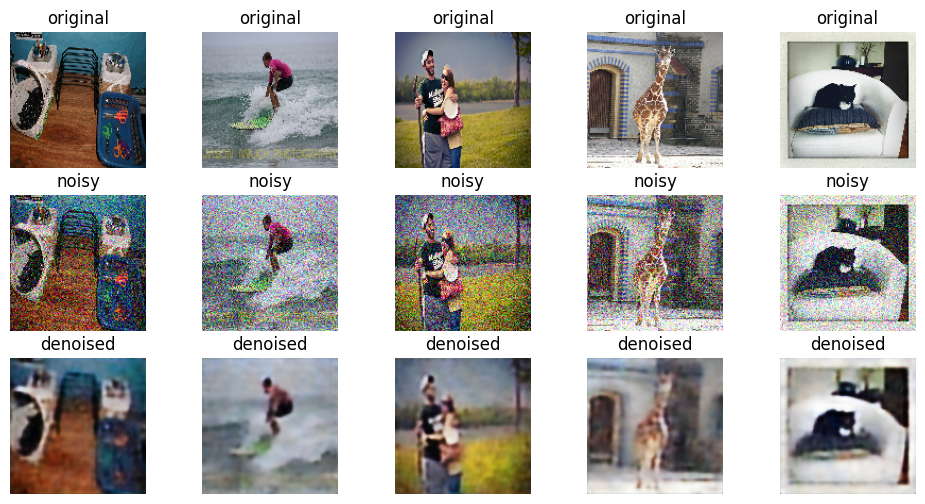

In [30]:
import matplotlib.pyplot as plt

# Take one batch from validation
for noisy, clean in val_pairs.take(1):
    recon = autoencoder.predict(noisy)

    n = min(5, noisy.shape[0])
    plt.figure(figsize=(12, 6))

    for i in range(n):
        # Clean
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(clean[i])
        plt.axis("off")
        ax.set_title("original")

        # Noisy
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i])
        plt.axis("off")
        ax.set_title("noisy")

        # Reconstructed
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(recon[i])
        plt.axis("off")
        ax.set_title("denoised")

    plt.show()
    break


What do you think of the model's performance?
<em>TO BE COMPLETED</em>


## 8. Saving the Model

Training the auto-encoder without using computing power (GPU) can take a long time. Usually, we save the trained model locally or on a remote server for later use in processing new data (by the way, you'll see an advanced use of this technique, transfer learning, next week).
To save the `autoencoder` model, use the `save` method.

In [31]:
# save the model
# save the model
autoencoder.save("denoising_autoencoder.h5")



## 9.Conclusion

In this project, a convolutional autoencoder was developed to perform image denoising on a small RGB image dataset. The model was trained using artificially corrupted images as inputs and their clean counterparts as targets, enabling it to learn meaningful feature representations that separate noise from important visual structures. Through appropriate preprocessing, noise injection, and the use of convolutional encoder–decoder architecture, the autoencoder demonstrated the ability to effectively reconstruct cleaner versions of noisy images.

Despite the limited dataset size, techniques such as data normalization, early stopping, and validation monitoring helped prevent overfitting and ensured stable training. The results show that convolutional autoencoders are a practical and flexible approach for image denoising tasks and can be adapted to different datasets with suitable preprocessing and architectural adjustments. Future work could explore deeper architectures, alternative loss functions, or more advanced denoising techniques to further improve reconstruction quality.